[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Charlie5DH/WSN/blob/master/Notebooks/RSSI_Data_Exploration.ipynb)

Sequence to sequence or Seq2Seq is a neural network that transforms a given sequence, like words or time series, into another sequence. **Seq2seq models consist of an Encoder and Decoder, the Encoder takes the input sequence and maps it into a higher dimensional space.** The n-dimensional vector is taken by the Decoder and turned into an output sequence. The output sequence can be in another language, can be a symbol, etc.

A very basic choice for the Encoder and the Decoder of the Seq2Seq model is a single LSTM for each of them.

## Attention Interfaces

When I’m translating a sentence, I pay special attention to the word I’m presently translating. When I’m transcribing an audio recording, I listen carefully to the segment I’m actively writing down. And if you ask me to describe the room I’m sitting in, I’ll glance around at the objects I’m describing as I do so. NN can achieve this principle using **attention**. Focusing on a subset of information they are given. For example an RNN can attend over the output of another RNN.

We’d like attention to be differentiable, so that we can learn where to focus. To do this, we use the same trick Neural Turing Machines use: we focus everywhere, just to different extents.
![../Images/Untitled.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled.png?raw=1)

The attention distribution is usually generated with content-based attention. The attending RNN generates a query describing what it wants to focus on. Each item is dot-producted with the query to produce a score, describing how well it matches the query. The scores are fed into a softmax to create the attention distribution.

![../Images/Untitled%201.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled%201.png?raw=1)

Say, we have a source sequence `x` (dates) of length `n` and try to output a target sequence `y` of length. `x = [x_1,...,x_n]` ; `y = [y1,...,y_m]`

The encoder is a bidirectional RNN (or other recurrent network setting of your choice) with a forward hidden state `h→i` and a backward one `h←i`. A simple concatenation of two represents the encoder state. The motivation is to include both the preceding and following words in the annotation of one word.

$$
h_i = [h_i^{\rightarrow T};h_i^{\leftarrow T}], i=1,...,nh_i = [h_i^{\rightarrow T};h_i^{\leftarrow T}], i=1,...,n
$$

The decoder has a **hidden state** $S_t=f(s_{t-1},y_{t-1}, c_t$ Which depends on the previous state, the previous output and a context vector for the output word at position `t`, $t=[t_1,...,t_m]$ where the context vector `C_t` is a sum of the hidden states of the input sequence weighted by alignment scores.

First calculate the attentions weights 
$$
\alpha=[\alpha_1,...\alpha_T] 
$$
based on the the encoded sequence `h=[h1,...h_T]` and the internal hidden state `S_{t-1}`.

![../Images/Untitled%203.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled%203.png?raw=1)

The alignment model assigns a score `α_t,i` to the pair of input at position `i` and output at position `t`, `(y_t,x_i)`, based on how well they match. 

Below is a summary table of several popular attention mechanisms and corresponding alignment score functions:

![../Images/Untitled%205.png](https://github.com/Charlie5DH/Attention-Models/blob/main/Images/Untitled%205.png?raw=1)

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [2]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
# this is for making Graphviz work (plot_model needs GraphViz)
from IPython.display import HTML
from keras.utils.vis_utils import plot_model, model_to_dot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.sys.path.append('..')
from utils.model_utils import serialize_model

Using TensorFlow backend.


In [3]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')

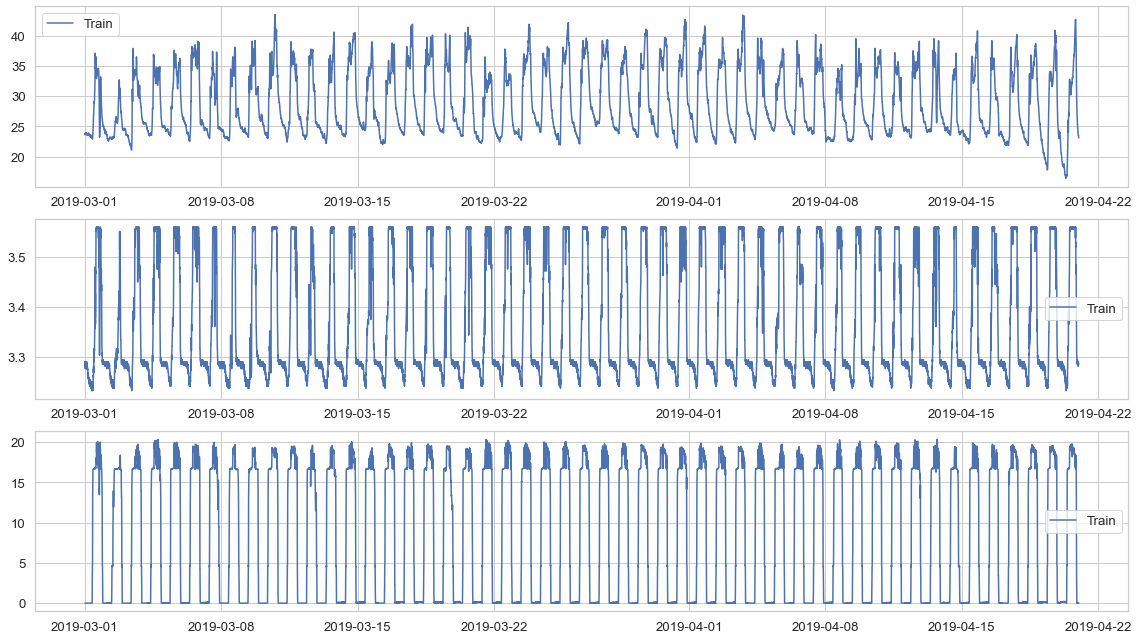

In [29]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

fig, axx = plt.subplots(3,1, figsize=(16,9))
for ii, ax in zip(train_data.columns, axx):
    ax.plot(train_data[ii], label='Train')
    ax.legend()
plt.tight_layout()

In [30]:
from sklearn.preprocessing import MinMaxScaler
train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

Lenght of Data 14688
Lenght of Train 11750


Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3d numpy arrays.

## Baseline LSTM

(11622, 128, 3) (11622, 3)
(2810, 128, 3) (2810, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128, 128)          67584     
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 199,555
Trainable params: 199,555
Non-trainable params: 0
_________________________________________________________________


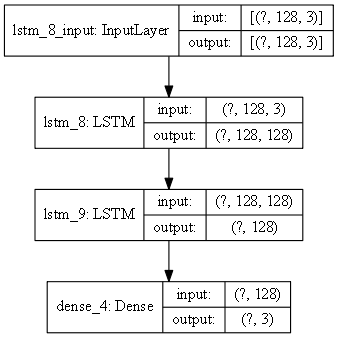

In [59]:
from utils.model_utils import split_sequences_multivariate

n_timesteps = 128
n_features = normalized_train.shape[-1]

train_X_lstm, train_y_lstm = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps)
test_X_lstm, test_y_lstm = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps)
#print('Training Shapes. X{}, y{} '.format(train_X_lstm.shape, train_y_lstm.shape))
#print('Testing Shapes. X{}, y{} '.format(test_X_lstm.shape, test_y_lstm.shape))

model_LSTM = tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                                    return_sequences=True, dropout=0.2))
model_LSTM.add(tf.keras.layers.LSTM(units=128, input_shape=(n_timesteps, n_features),
                                    return_sequences=False, dropout=0.2))
#model_LSTM.add(tf.keras.layers.BatchNormalization())
model_LSTM.add(tf.keras.layers.Dense(n_features))

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

model_LSTM.summary()
tf.keras.utils.plot_model(model_LSTM, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

In [60]:
epochs = 100
batch_size = 64

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model_LSTM.fit(train_X_lstm, train_y_lstm,
                         validation_split=0.2, 
                         epochs=epochs, verbose=1,
                         callbacks=[early_stop], 
                         batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

Epoch 1/100
146/146 [==============================] - 62s 427ms/step - loss: 0.0337 - mae: 0.0962 - val_loss: 0.0062 - val_mae: 0.0547
Epoch 2/100
146/146 [==============================] - 61s 421ms/step - loss: 0.0079 - mae: 0.0585 - val_loss: 0.0042 - val_mae: 0.0397
Epoch 3/100
146/146 [==============================] - 60s 408ms/step - loss: 0.0064 - mae: 0.0526 - val_loss: 0.0042 - val_mae: 0.0430
Epoch 4/100
146/146 [==============================] - 60s 409ms/step - loss: 0.0053 - mae: 0.0464 - val_loss: 0.0091 - val_mae: 0.0632
Epoch 5/100
146/146 [==============================] - 59s 401ms/step - loss: 0.0042 - mae: 0.0419 - val_loss: 0.0059 - val_mae: 0.0477


In [59]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    name= '/tmp/model_lstm' + str(epochs)+ '_' + str(batch_size)
    serialize_model(model_LSTM, history_df, name= name)
else:
    name= 'Weights//model_lstm' + str(epochs)+ '_' + str(batch_size)
    serialize_model(model_LSTM, history_df, name= name)

Saved model to disk


In [61]:
def plot_model_results(model, history_df, X, y, feature_index=0):
    '''
    Plot the scores of the model and the prediction vs the
    real time series
    '''
    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1),
                                                     y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    
    fig = plt.figure(figsize=(24,5))
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3])
    ax0 = fig.add_subplot(spec[0])
    sns.lineplot(data=history_df[['mae','val_mae']], markers=True)
    # plot the prediction and the reality (for the test data)
    ax1 = fig.add_subplot(spec[1])
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth')    
    plt.tight_layout()

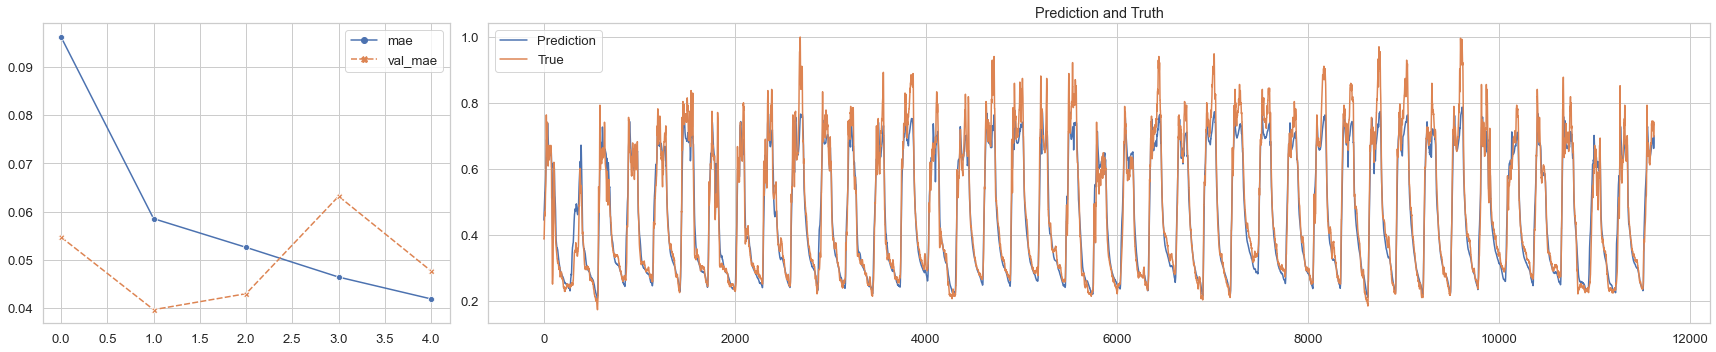

In [62]:
plot_model_results(model_LSTM, history_df, train_X_lstm, train_y_lstm)

(11622, 128, 3) (11622, 3)
(11622, 3) (2810, 3)


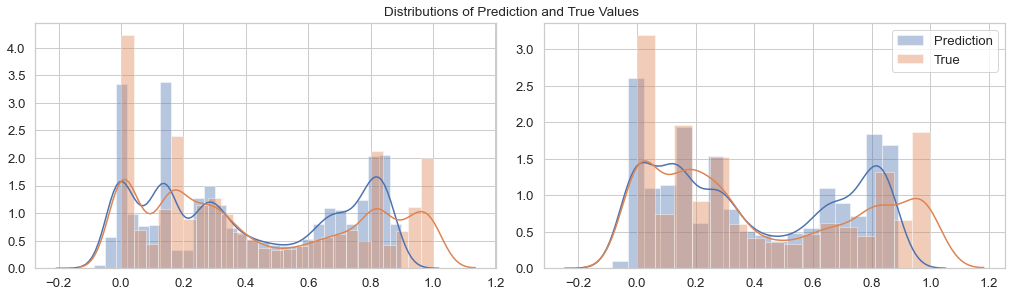

In [68]:
train_predictions = model_LSTM.predict(train_X_lstm)
test_predictions = model_LSTM.predict(test_X_lstm)

# X_output are the true values for the predictions
print(train_X_lstm.shape, train_y_lstm.shape)
print(train_predictions.shape, test_predictions.shape)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
sns.distplot(a=train_y_lstm.flatten(), ax=ax1, label= 'True')
sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
sns.distplot(a=test_y_lstm.flatten(), ax=ax2, label='True')
plt.legend()
plt.tight_layout()

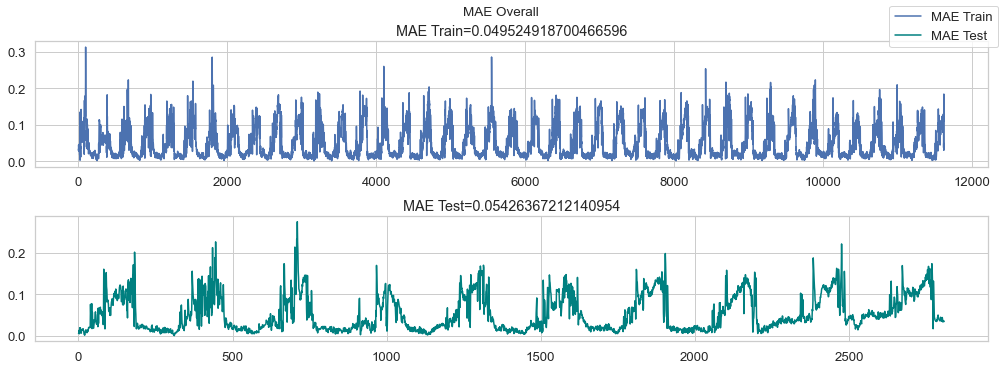

In [69]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,5))
fig.suptitle('MAE Overall', y=1.02, fontsize=13.5)

MAE = abs(train_predictions - train_y_lstm).mean()
mae_overall = abs(train_predictions-train_y_lstm).mean(axis=(1))
ax1.plot(mae_overall, label='MAE Train')
ax1.set_title('MAE Train={}'.format(MAE))

MAE = abs(test_predictions - test_y_lstm).mean()
mae_overall = abs(test_predictions-test_y_lstm).mean(axis=(1))
ax2.plot(mae_overall, label='MAE Test', color='teal')
ax2.set_title('MAE Test={}'.format(MAE))

fig.legend(loc='upper right')
plt.tight_layout()

## Simple LSTM Seq2Seq

## Create Sequences
Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3D numpy arrays. The function truncate generates 3 arrays:
- input to neural network X_in: it contains 781 samples, length of each sample is 200 time steps, and each sample contains 3 features: detrended and normalised x1, detrended and normalised x2, and original assigned data position index. Only the first 2 features will be used for training.
- target in neural network X_out: it contains 781 samples, length of each sample is 20 time steps, and each sample contains the same 3 features as in X_in. Only the first 2 features will be used as target, and the third feature will only be used to recover trend of the prediction.
- label lbl: 1 for train set and 0 for test set.

In [48]:
# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [49]:
n_timesteps_in = 128
n_timesteps_out = 8
n_samples = 3

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
print(train_X.shape, test_y.shape)
print(test_X.shape, test_y.shape)

(11615, 128, 3) (2803, 8, 3)
(2803, 128, 3) (2803, 8, 3)


The output of an LSTM cell or layer of cells is called the hidden state.

**The encoder LSTM cell**: The value of each time step is input into the encoder LSTM cell together with previous cell state c and hidden state h, the process repeats until the last cell state c and hidden state h are generated.

**The decoder LSTM cell**: We use the last cell state c and hidden state h from the encoder as the initial states of the decoder LSTM cell. The last hidden state of encoder is also copied 20 times, and each copy is input into the decoder LSTM cell together with previous cell state c and hidden state h. The decoder outputs hidden state for all the 20 time steps, and these hidden states are connected to a dense layer to output the final result.

We use `return_state=True`. Keras provides the `return_state` argument to the LSTM layer that will provide access to the hidden state output (state_h) and the cell state (state_c). This returns 3 arrays:
- The LSTM hidden state output for the last time step.
- The LSTM hidden state output for the last time step (again).
- The LSTM cell state for the last time step.

The hidden state and the cell state could in turn be used to initialize the states of another LSTM layer with the same number of cells.

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 128), (None, 67584       input_5[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 8, 128)       0           lstm_6[0][0]                     
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 8, 128)       131584      repeat_vector_2[0][0]            
                                                                 lstm_6[0][0]          

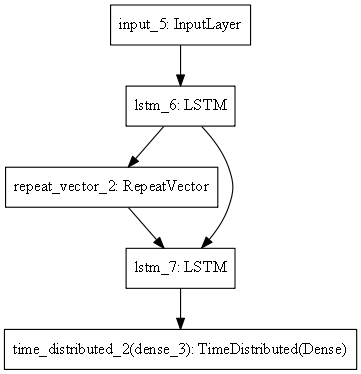

In [50]:
# Hidden Layers
n_hidden = 128
input_timesteps = n_timesteps_in
input_features = n_samples = 3

input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))

encoder_last_h1, encoder_last_h2, encoder_last_c = \
tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=0.2,
                     return_sequences=False,
                     return_state=True)(input_train)

# Batch normalisation is added because we want to avoid gradient
# explosion caused by the activation function ELU in the encoder.
#encoder_last_h1 = BatchNormalization(momentum=0.9)(encoder_last_h1)
#encoder_last_c = BatchNormalization(momentum=0.9)(encoder_last_c)

# Create copies of las hidden state
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

# nitial_state: List of initial state tensors to be passed to the first call of the cell 
#(optional, defaults to None which causes creation of zero-filled initial state tensors).
# In this case initial state is the output from encoder
decoder = tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=0.2,
                               return_state=False,
                               return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
model = Model(inputs=input_train, outputs=out)

optimizer = tf.keras.optimizers.Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

In [51]:
epochs = 100
batch_size = 64

In [52]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

history = model.fit(train_X, train_y,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

Epoch 1/100
146/146 [==============================] - 17s 118ms/step - loss: 0.0295 - mae: 0.1054 - val_loss: 0.0213 - val_mae: 0.1029
Epoch 2/100
146/146 [==============================] - 20s 139ms/step - loss: 0.0096 - mae: 0.0607 - val_loss: 0.0210 - val_mae: 0.1044
Epoch 3/100
146/146 [==============================] - 20s 136ms/step - loss: 0.0079 - mae: 0.0532 - val_loss: 0.0199 - val_mae: 0.1030
Epoch 4/100
146/146 [==============================] - 19s 132ms/step - loss: 0.0066 - mae: 0.0479 - val_loss: 0.0189 - val_mae: 0.1008
Epoch 5/100
146/146 [==============================] - 20s 139ms/step - loss: 0.0064 - mae: 0.0463 - val_loss: 0.0185 - val_mae: 0.0945
Epoch 6/100
146/146 [==============================] - 20s 139ms/step - loss: 0.0062 - mae: 0.0455 - val_loss: 0.0132 - val_mae: 0.0848
Epoch 7/100
146/146 [==============================] - 20s 140ms/step - loss: 0.0057 - mae: 0.0430 - val_loss: 0.0111 - val_mae: 0.0709
Epoch 8/100
146/146 [===========================

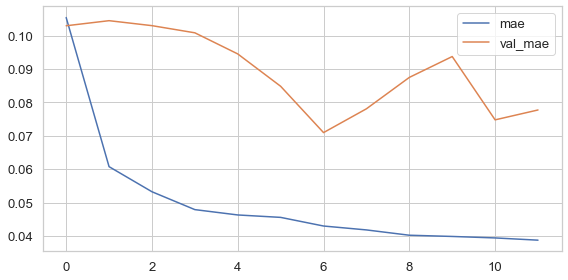

In [53]:
history_df.plot(figsize=(8,4))
plt.tight_layout()

In [68]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    name= '/tmp/model_seq2seq' + str(epochs)+ '_' + str(batch_size)
    serialize_model(model, history_df, name= name)
else:
    name= 'Weights//model_seq2seq' + str(epochs)+ '_' + str(batch_size)
    serialize_model(model, history_df, name= name)

Saved model to disk


(11615, 128, 3) (11615, 8, 3)
(11615, 8, 3) (2803, 8, 3)


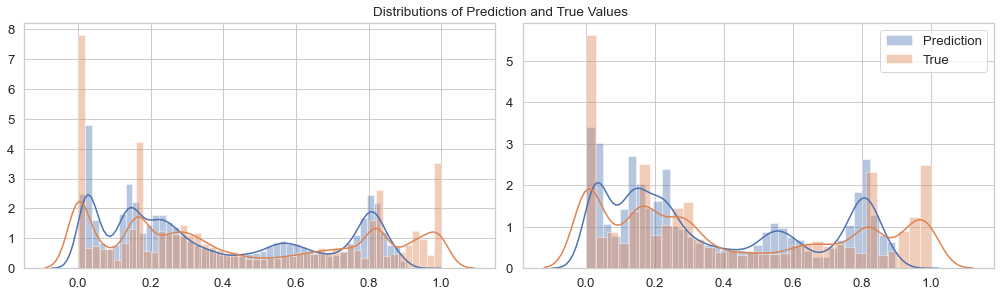

In [57]:
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

# X_output are the true values for the predictions
print(train_X.shape, train_y.shape)
print(train_predictions.shape, test_predictions.shape)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
sns.distplot(a=train_y.flatten(), ax=ax1, label= 'True')
sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
sns.distplot(a=test_y.flatten(), ax=ax2, label='True')
plt.legend()
plt.tight_layout()

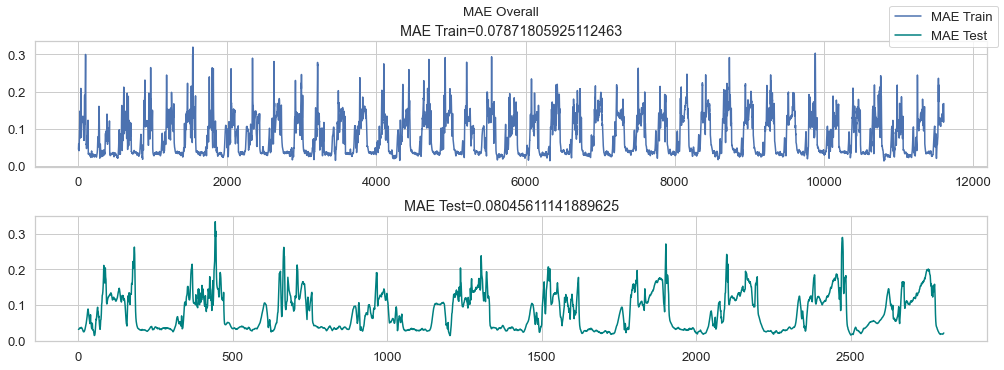

In [55]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,5))
fig.suptitle('MAE Overall', y=1.02, fontsize=13.5)

MAE = abs(train_predictions - train_y).mean()
mae_overall = abs(train_predictions-train_y).mean(axis=(1,2))
ax1.plot(mae_overall, label='MAE Train')
ax1.set_title('MAE Train={}'.format(MAE))

MAE = abs(test_predictions - test_y).mean()
mae_overall = abs(test_predictions-test_y).mean(axis=(1,2))
ax2.plot(mae_overall, label='MAE Test', color='teal')
ax2.set_title('MAE Test={}'.format(MAE))

fig.legend(loc='upper right')
plt.tight_layout()

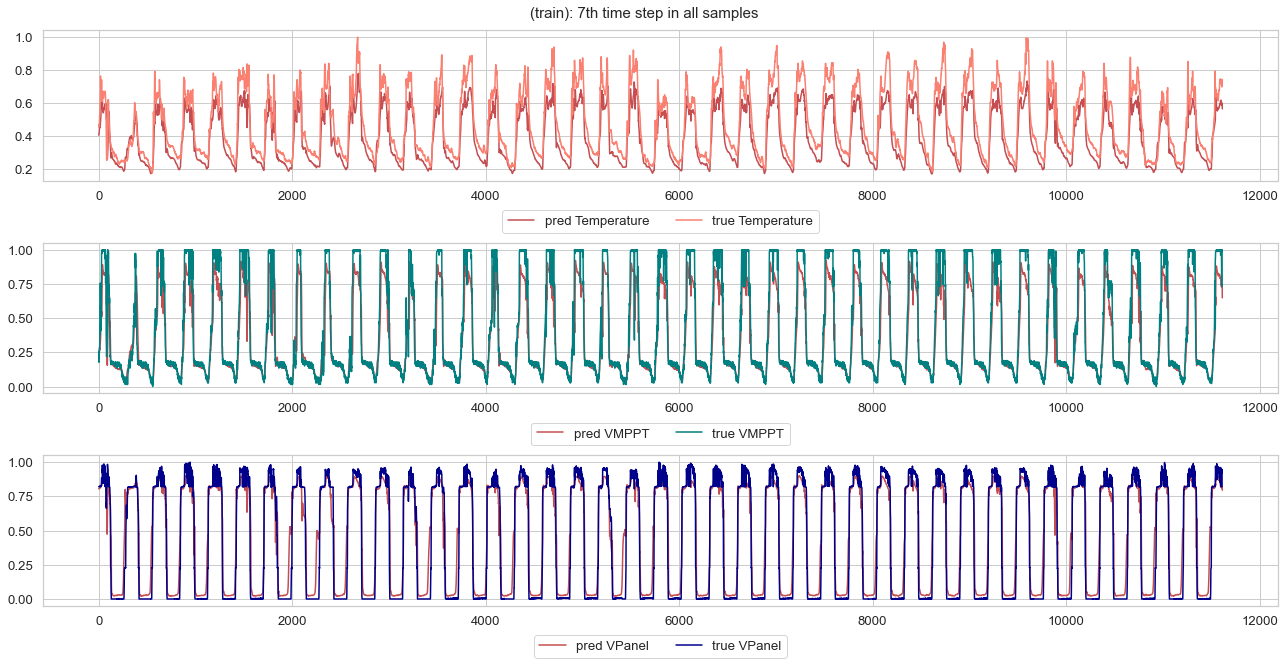

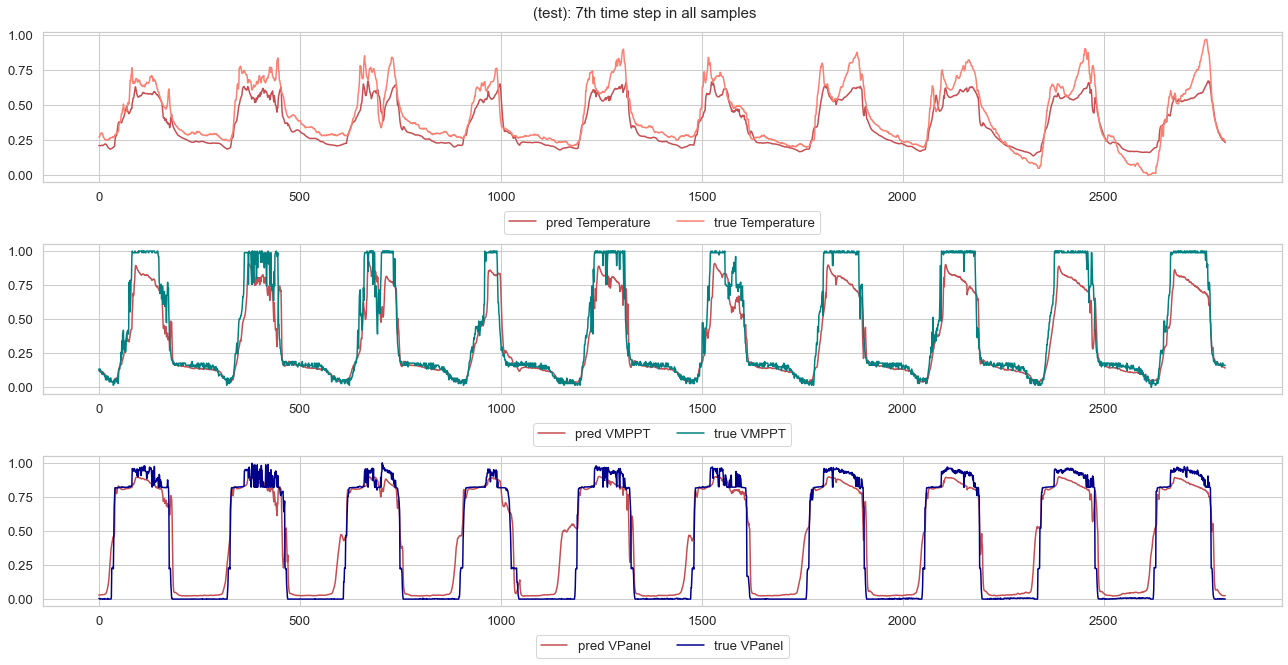

In [58]:
data_final = dict(train_pred=train_predictions, train_true=train_y,
                  test_pred=test_predictions, test_true=test_y)

# Number of time steps in the future, as increases the accuracy decreases
ith_timestep = 7

for lb in ['train', 'test']:   
    fig, axx = plt.subplots(3,1,figsize=(18,9))
    for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
        axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
        axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
        axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
    plt.tight_layout()

# Adding Luong Attention

One of the limitations of simple Seq2Seq model is: only the last state of encoder RNN is used as input to decoder RNN. If the sequence is very long, the encoder will tend to have much weaker memory about earlier time steps. Attention mechanism can solve this problem. An attention layer is going to assign proper weight to each hidden state output from encoder, and map them to output sequence.

In this case besides returning the last hidden state and the last cell state of the encoder, we also need to return the stacked hidden states for alignment score calculation. We need all the hidden states of the LSTM.

In [75]:
n_timesteps_in = 128
n_timesteps_out = 8
n_samples = 3

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(11615, 128, 3) (11615, 8, 3)
(2803, 128, 3) (2803, 8, 3)


In [76]:
# Encoder Decoder Layers
n_hidden = 128

input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))

# The encoder now returns
encoder_stack_h, encoder_last_h, encoder_last_c = tf.keras.layers.LSTM(n_hidden, activation='tanh',
                                                                       dropout=0.2, return_sequences=True, 
                                                                       return_state=True)(input_train)

# Adding Batch Regularization to avoid gradient explotion(optional)
#encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
#encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh',
                                       dropout=0.2, recurrent_dropout=0.2, return_state=False,
                                       return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(input_train)
print(output_train)
print(decoder_stack_h)
print(decoder_input)

Tensor("input_9:0", shape=(None, 128, 3), dtype=float32)
Tensor("input_10:0", shape=(None, 8, 3), dtype=float32)
Tensor("lstm_13/transpose_1:0", shape=(None, 8, 128), dtype=float32)
Tensor("repeat_vector_4/Tile:0", shape=(None, 8, 128), dtype=float32)


### Attention Layer
To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [77]:
# Alignment Score is Dot Product in Luong Attention
attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
print(attention)

context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
#context = BatchNormalization(momentum=0.6)(context)
print(context)

# Now we concat the context vector and stacked hidden states of decoder, 
# and use it as input to the last dense layer.
decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
print(decoder_combined_context)

out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("Softmax/truediv_3:0", shape=(None, 8, 128), dtype=float32)
Tensor("dot_7/MatMul:0", shape=(None, 8, 128), dtype=float32)
Tensor("concatenate_3/concat:0", shape=(None, 8, 256), dtype=float32)
Tensor("time_distributed_4/Reshape_1:0", shape=(None, 8, 3), dtype=float32)


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 128, 128), ( 67584       input_9[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 8, 128)       0           lstm_12[0][1]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 8, 128)       131584      repeat_vector_4[0][0]            
                                                                 lstm_12[0][1]         

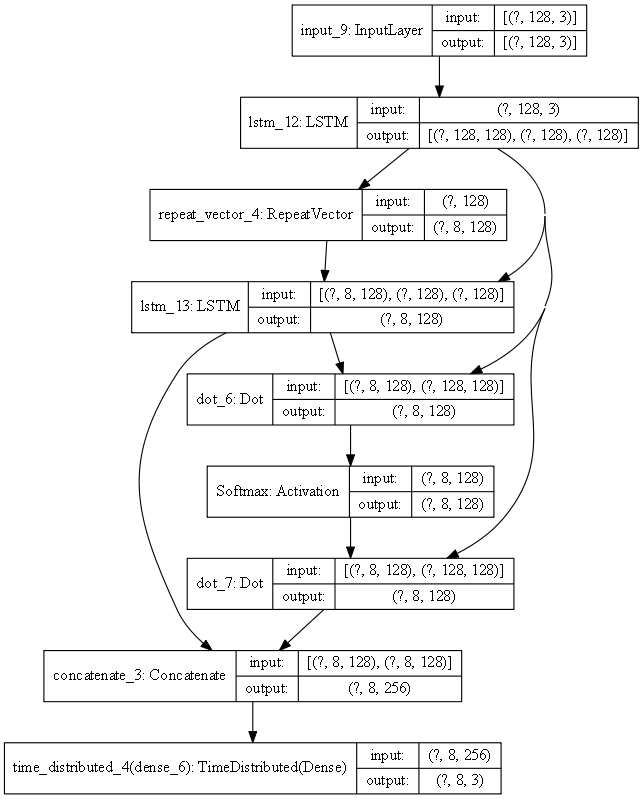

In [78]:
model = tf.keras.models.Model(inputs=input_train, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
#model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

In [79]:
epochs = 100
batch_size = 64

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=6)

history = model.fit(train_X, train_y,
                    validation_split=0.2, 
                    epochs=epochs, verbose=1,
                    callbacks=[early_stop], 
                    batch_size=batch_size)

history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])

Epoch 1/100
146/146 [==============================] - 34s 231ms/step - loss: 0.0123 - mae: 0.1005 - val_loss: 0.0050 - val_mae: 0.0636
Epoch 2/100
146/146 [==============================] - 32s 218ms/step - loss: 0.0062 - mae: 0.0743 - val_loss: 0.0040 - val_mae: 0.0565
Epoch 3/100
146/146 [==============================] - 34s 230ms/step - loss: 0.0053 - mae: 0.0677 - val_loss: 0.0036 - val_mae: 0.0532
Epoch 4/100
146/146 [==============================] - 31s 214ms/step - loss: 0.0046 - mae: 0.0637 - val_loss: 0.0034 - val_mae: 0.0532
Epoch 5/100
146/146 [==============================] - 33s 223ms/step - loss: 0.0041 - mae: 0.0590 - val_loss: 0.0030 - val_mae: 0.0477
Epoch 6/100
146/146 [==============================] - 31s 213ms/step - loss: 0.0036 - mae: 0.0543 - val_loss: 0.0027 - val_mae: 0.0451
Epoch 7/100
146/146 [==============================] - 30s 209ms/step - loss: 0.0036 - mae: 0.0528 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 8/100
146/146 [===========================

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Saved tn CoLab')
    name= '/tmp/model_seq2seq+att' + str(epochs)+ '_' + str(batch_size)
    serialize_model(model, history_df, name= name)
else:
    name='Weights/model_seq2seq+att' + str(epochs)+ '_' + str(batch_size)
    serialize_model(model, history_df, name= name)

(11615, 128, 3) (11615, 8, 3)
(11615, 8, 3) (2803, 8, 3)


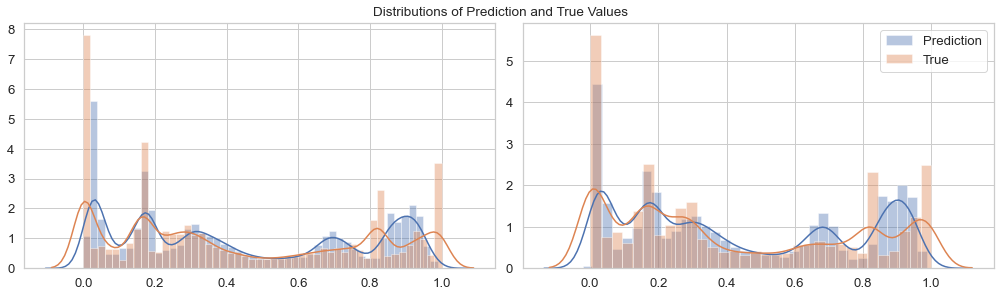

In [80]:
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

# X_output are the true values for the predictions
print(train_X.shape, train_y.shape)
print(train_predictions.shape, test_predictions.shape)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
sns.distplot(a=train_y.flatten(), ax=ax1, label= 'True')
sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
sns.distplot(a=test_y.flatten(), ax=ax2, label='True')
plt.legend()
plt.tight_layout()

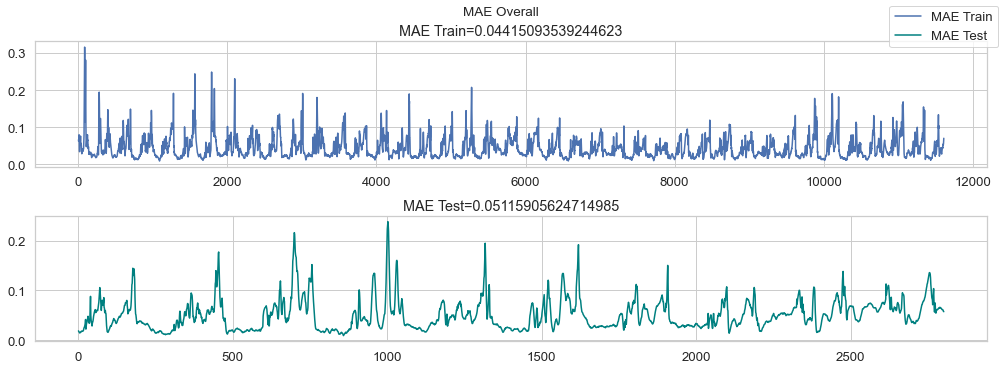

In [81]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,5))
fig.suptitle('MAE Overall', y=1.02, fontsize=13.5)

MAE = abs(train_predictions - train_y).mean()
mae_overall = abs(train_predictions-train_y).mean(axis=(1,2))
ax1.plot(mae_overall, label='MAE Train')
ax1.set_title('MAE Train={}'.format(MAE))

MAE = abs(test_predictions - test_y).mean()
mae_overall = abs(test_predictions-test_y).mean(axis=(1,2))
ax2.plot(mae_overall, label='MAE Test', color='teal')
ax2.set_title('MAE Test={}'.format(MAE))

fig.legend(loc='upper right')
plt.tight_layout()

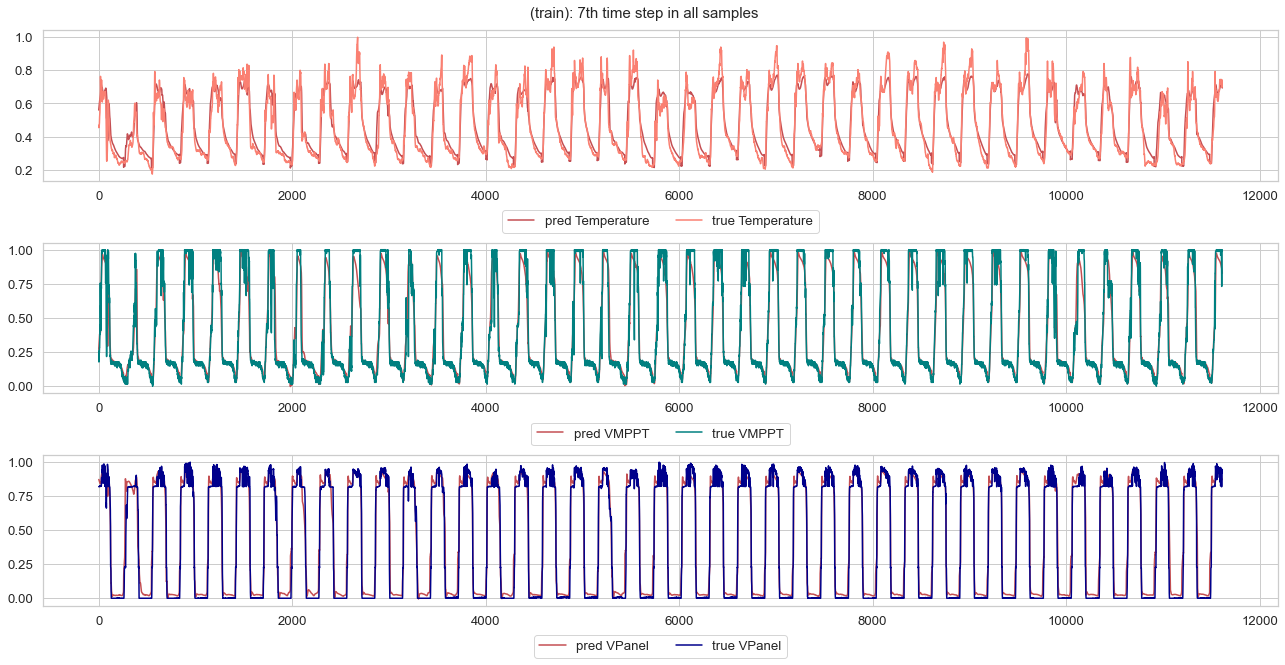

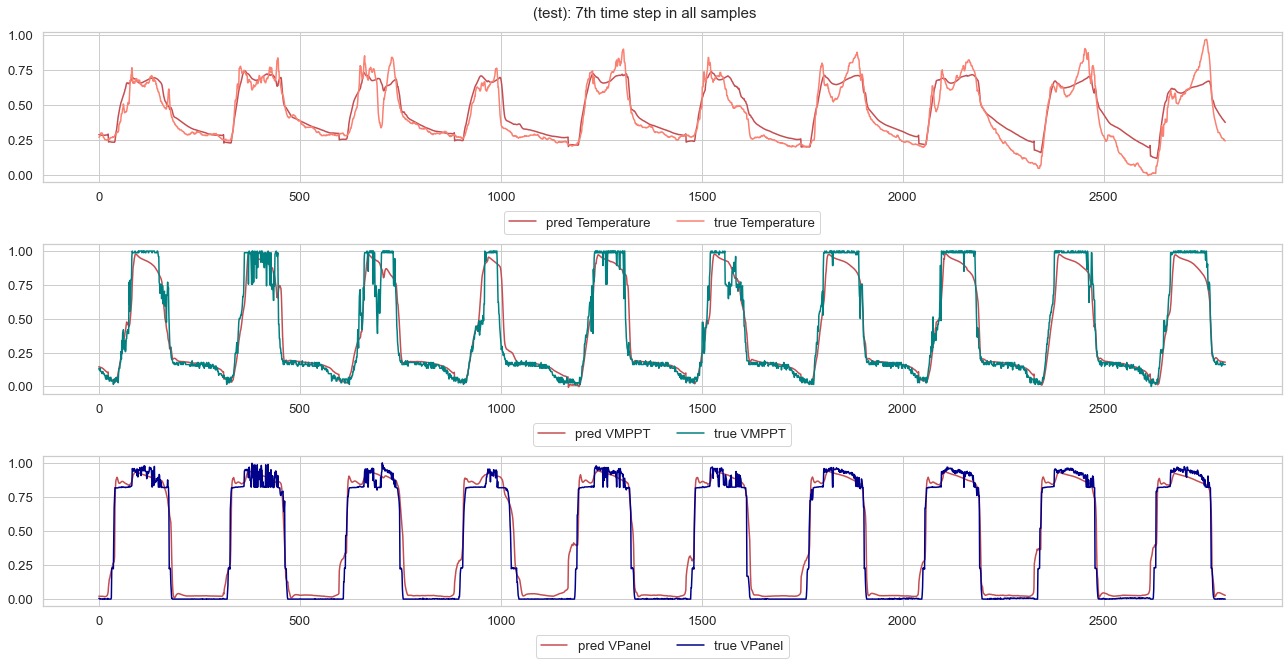

In [82]:
data_final = dict(train_pred=train_predictions, train_true=train_y,
                  test_pred=test_predictions, test_true=test_y)

# Number of time steps in the future, as increases the accuracy decreases
ith_timestep = 7

for lb in ['train', 'test']:   
    fig, axx = plt.subplots(3,1,figsize=(18,9))
    for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
        axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
        axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
        axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
    plt.tight_layout()

## Multiple Steps Forecast

In [46]:
# first set of samples
batch = train_X[-1, :, :]
predictions_forecast = batch
# 10 times X horizon timesteps
for i in range(10):
    one_step_pred = model.predict(batch.reshape(1, n_timesteps_in, n_features))
    batch = np.concatenate([batch[n_timesteps_out:], one_step_pred.reshape(n_timesteps_out, n_features)], axis=0)
    predictions_forecast = np.row_stack([predictions_forecast, one_step_pred.reshape(n_timesteps_out, n_features)])

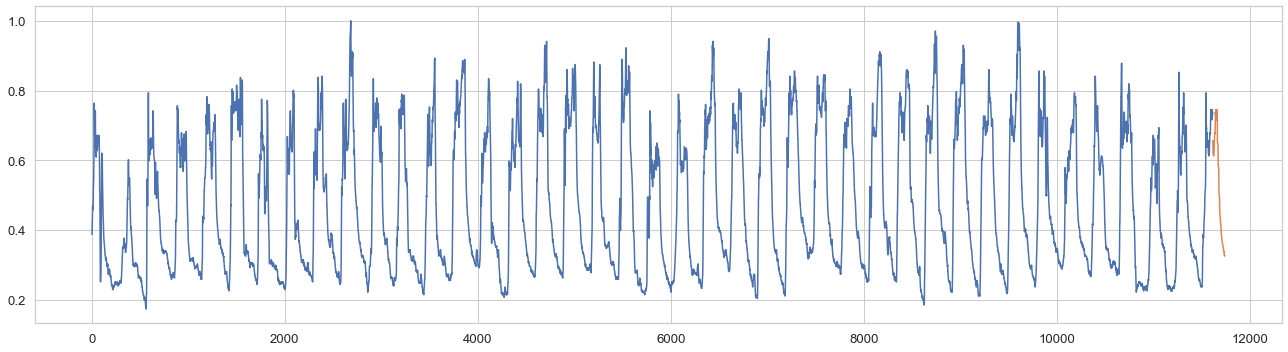

In [47]:
fig, axx = plt.subplots(1, 1, figsize=(18,5))

forecast = np.concatenate([train_y[:, 7, 0], batch[:,0]], axis=0)
forecast[:train_y.shape[0]] = None
axx.plot(train_y[:, 0, 0])
axx.plot(forecast)
plt.tight_layout()

### LSTM multiple steps forecast

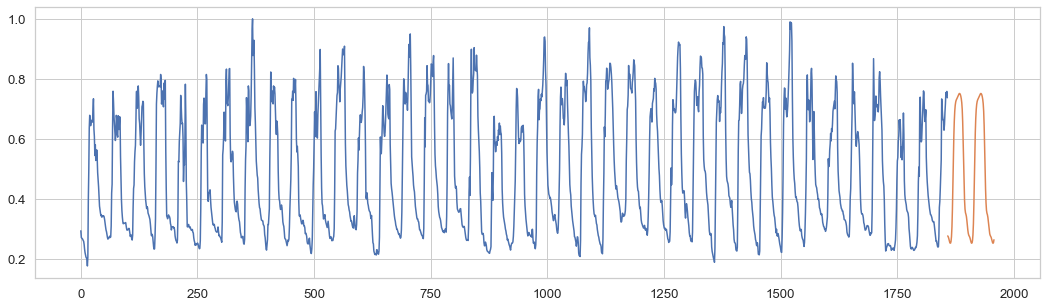

In [387]:
# first set of samples
batch = train_X_lstm[-1, :, :]
predictions_forecast = batch
# 10 times X horizon timesteps
for i in range(test_y_lstm.shape[0]):
    one_step_pred = model_LSTM.predict(batch.reshape(1, n_timesteps_in, n_features))
    batch = np.concatenate([batch[1:], one_step_pred.reshape(1, n_features)], axis=0)
    predictions_forecast = np.row_stack([predictions_forecast, one_step_pred.reshape(1, n_features)])

fig, axx = plt.subplots(1, 1, figsize=(18,5))
forecast = np.concatenate([train_y_lstm[:, 0], batch[:,0]], axis=0)
forecast[:train_y_lstm.shape[0]] = None
axx.plot(train_y_lstm[:, 0])
axx.plot(forecast)
plt.tight_layout()

## Try multiple horizons

In [348]:
# Try different Horizons
horizons = [4,8,16,24,32]
history_list = []
model_list = []

for ii in range(len(horizons)):
    
    n_timesteps_in = 100
    n_timesteps_out = horizons[ii]
    n_samples = 3

    train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
    test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
    print(train_X.shape, train_y.shape)
    print(test_X.shape, test_y.shape)
    
    n_hidden = 128

    input_train = Input(shape=(train_X.shape[1], train_X.shape[2]))
    output_train = Input(shape=(train_y.shape[1], train_y.shape[2]))
    encoder_stack_h, encoder_last_h, encoder_last_c = tf.keras.layers.LSTM(n_hidden, activation='tanh',
                                                                           dropout=0.2, return_sequences=True, 
                                                                           return_state=True)(input_train)
    decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)
    decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh',
                                           dropout=0.2, return_state=False,
                                           return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    
    attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = tf.keras.layers.Activation('softmax')(attention)
    context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
    decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)

    model = tf.keras.models.Model(inputs=input_train, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    epochs = 100
    batch_size = 64

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=6)

    history = model.fit(train_X, train_y,
                        validation_split=0.2, 
                        epochs=epochs, verbose=2,
                        callbacks=[early_stop], 
                        batch_size=batch_size)
    
    model_list.append(model)
    history_list.append(pd.DataFrame(history.history, columns=['mae', 'val_mae']))

(1855, 100, 3) (1855, 4, 3)
(387, 100, 3) (387, 4, 3)
Epoch 1/100
24/24 - 4s - loss: 0.0946 - mae: 0.2329 - val_loss: 0.0324 - val_mae: 0.1471
Epoch 2/100
24/24 - 4s - loss: 0.0359 - mae: 0.1451 - val_loss: 0.0239 - val_mae: 0.1152
Epoch 3/100
24/24 - 3s - loss: 0.0247 - mae: 0.1169 - val_loss: 0.0175 - val_mae: 0.0985
Epoch 4/100
24/24 - 3s - loss: 0.0199 - mae: 0.1011 - val_loss: 0.0142 - val_mae: 0.0874
Epoch 5/100
24/24 - 4s - loss: 0.0164 - mae: 0.0891 - val_loss: 0.0181 - val_mae: 0.0830
Epoch 6/100
24/24 - 4s - loss: 0.0186 - mae: 0.0909 - val_loss: 0.0198 - val_mae: 0.0890
Epoch 7/100
24/24 - 4s - loss: 0.0163 - mae: 0.0846 - val_loss: 0.0101 - val_mae: 0.0703
Epoch 8/100
24/24 - 4s - loss: 0.0133 - mae: 0.0759 - val_loss: 0.0098 - val_mae: 0.0653
Epoch 9/100
24/24 - 4s - loss: 0.0125 - mae: 0.0729 - val_loss: 0.0103 - val_mae: 0.0644
Epoch 10/100
24/24 - 3s - loss: 0.0117 - mae: 0.0708 - val_loss: 0.0098 - val_mae: 0.0657
Epoch 11/100
24/24 - 3s - loss: 0.0115 - mae: 0.0685 - 

MAE for training and testing sets in with different horizons
[0.04659805951718085, 0.06293863795024157, 0.062455934489067486, 0.05440587938112337, 0.05177507779419979]
[0.06076450141151237, 0.07555644392150436, 0.0769147560661473, 0.0682697403493784, 0.06835097267135762]


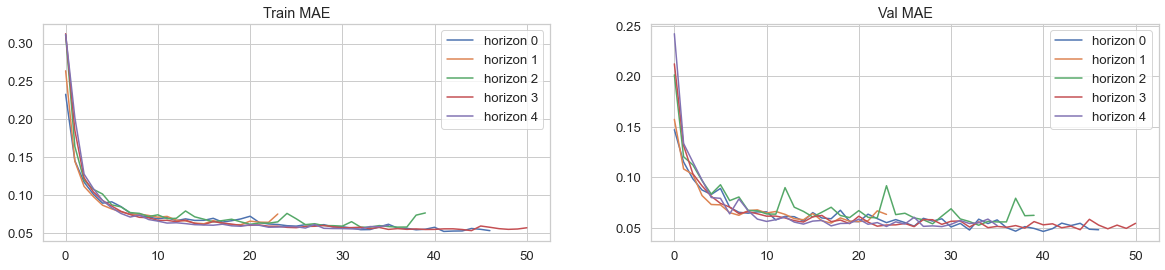

In [349]:
train_predictions_list = []
test_predictions_list = []
MAE_train = []
MAE_test = []
mae_overall_train_list = []
mae_overall_test_list = []

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
for i in range(len(horizons)):
    history_list[i]['mae'].plot(ax=ax1, label=('horizon {}'.format(i)), title='Train MAE')
    history_list[i]['val_mae'].plot(ax=ax2, label=('horizon {}'.format(i)), title='Val MAE')
    ax1.legend(); ax2.legend()
    plt.tight_layout()
    
    train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=horizons[i])
    test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=horizons[i])
    
    train_predictions_list.append(model_list[i].predict(train_X))
    test_predictions_list.append(model_list[i].predict(test_X))
    MAE_train.append(abs(train_predictions_list[i] - train_y).mean())
    mae_overall_train_list.append(abs(train_predictions_list[i]-train_y).mean(axis=(1,2)))
    MAE_test.append(abs(test_predictions_list[i] - test_y).mean())
    mae_overall_test_list.append(abs(test_predictions_list[i]-test_y).mean(axis=(1,2)))
    
print('MAE for training and testing sets in with different horizons')
print(MAE_train)
print(MAE_test)